## TOC
* [Model RDM](#modelrdm-bullet)
* [Model comparison](#modelcompare-bullet)
    * [Functions](#functions-bullet)
    * [Bartra ROIs](#bartra)
    * [Med > Mon parahippocampal areas](#hippo)

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
import scipy.spatial.distance as sp_distance

import nibabel as nib
import nilearn.plotting as plotting
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from nltools.mask import create_sphere

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

/gpfs/ysm/project/rj299/conda_envs/py37_dev/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Autosaving every 5 seconds


In [2]:
base_root = '/home/rj299/scratch60/mdm_analysis/'
data_root = '/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/1stLevel/'
out_root = '/home/rj299/scratch60/mdm_analysis/output/'
anat_mean = nib.load(os.path.join(out_root, 'imaging', 'all_sub_average.nii.gz'))

In [3]:
stims = {'01': 'Med_amb_0', '02': 'Med_amb_1', '03': 'Med_amb_2', '04': 'Med_amb_3',
         '05': 'Med_risk_0', '06': 'Med_risk_1', '07': 'Med_risk_2', '08': 'Med_risk_3', 
         '09': 'Mon_amb_0', '10': 'Mon_amb_1', '11': 'Mon_amb_2', '12': 'Mon_amb_3',
         '13': 'Mon_risk_0', '14': 'Mon_risk_1', '15': 'Mon_risk_2', '16': 'Mon_risk_3'}

stim_num = len(stims)

subjects = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 
            2593, 2594, 2596, 2597, 2598, 2599, 2600, 2624, 
            2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 
            2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666]

In [4]:
# all rois' names
sub = 2654
roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
              allow_pickle = True)
roi_rdm = roi_rdm_obj.item()
roi_names_all = list(roi_rdm.keys())

print('All names of ROIs:')
for roi_name in roi_names_all:
    print(roi_name)

All names of ROIs:
vmpfc
vstr
med_mon_1
med_mon_2
med_mon_3
gilaie_rppc
zhang_val_lppc
zhang_val_lofc
zhang_val_rofc
zhang_val_lingual
zhang_sal_acc
zhang_sal_lprecentral
zhang_sal_lcaudate
zhang_sal_rcaudate
zhang_sal_linsula
zhang_sal_rinsula
zhang_sal_lingual
levy_amb_striatum
levy_amb_mpfc
levy_amb_ppc
levy_amb_lamyg
levy_amb_sts
levy_risk_striatum
levy_risk_mpfc


## Model RDM <a class="anchor" id="modelrdm-bullet"></a>

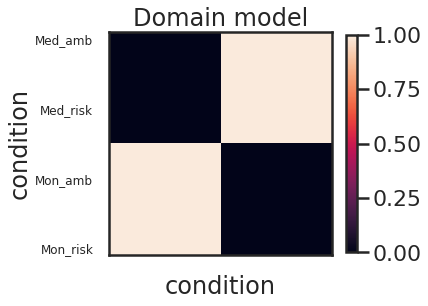

In [5]:
# Model RDM domain difference
mod_rdm_domain = np.ones([16,16])

med_id = list(range(8))
mon_id = list(range(8,16))

mon_mask = [(a,b) for a in mon_id for b in mon_id]
med_mask = [(a,b) for a in med_id for b in med_id]

for mon_mask_idx in mon_mask:  
    mod_rdm_domain[mon_mask_idx] = 0
for med_mask_idx in med_mask:  
    mod_rdm_domain[med_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 12}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_domain)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Domain model') 
ax.set_ylabel('condition')
ax.set_xlabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

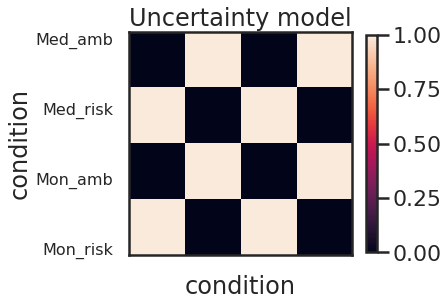

In [6]:
# Model RDM risk/ambig difference
mod_rdm_uncert = np.ones([16,16])

risk_id = [0,1,2,3,8,9,10,11]
amb_id = [4,5,6,7,12,13,14,15]

amb_mask = [(a,b) for a in risk_id for b in risk_id]
risk_mask = [(a,b) for a in amb_id for b in amb_id]

for risk_mask_idx in risk_mask:  
    mod_rdm_uncert[risk_mask_idx] = 0
for amb_mask_idx in amb_mask:  
    mod_rdm_uncert[amb_mask_idx] = 0

stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_uncert)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Uncertainty model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)

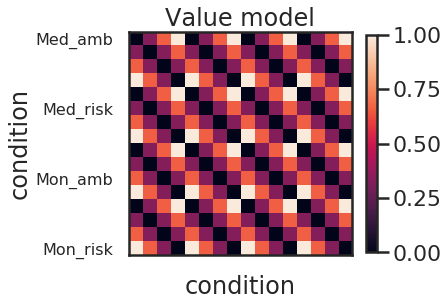

In [7]:
# Model RDM value (outcome magnitude) difference
mod_rdm_val = np.ones([16,16])

level = np.array([0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3])

for i in range(len(level)):
    for j in range(len(level)):
        mod_rdm_val[i, j] = abs(level[i] - level[j])/3
        
stim_cat = ['', 'Med_amb', 'Med_risk', 'Mon_amb', 'Mon_risk']
fontdict = {'fontsize': 16}
edges = np.array([0,4,8,12,16])-0.5

f, ax = plt.subplots(1,1, figsize=(5, 5))
im0 = ax.imshow(mod_rdm_val)
ax.set_xticklabels([])
ax.set_yticklabels(stim_cat, fontdict = fontdict)
ax.set_title('Value model') 
ax.set_xlabel('condition')
ax.set_ylabel('condition')
# ax.vlines(edges,min(edges),max(edges))
# ax.hlines(edges,min(edges),max(edges))
f.colorbar(im0, ax=ax, shrink = 0.8)        

In [11]:
# value model based on each individual's rating
def rating_model(sub_id, ratings):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-11-c55563e7f2bf>, line 3)

## Model comparison <a class="anchor" id="modelcompare-bullet"></a>

In [17]:
def half_matrix(matrix):
    ''' Take half of the correlation matrix, excluding diagnoal
    Input:
        matrix
    
    Output:
        half_matrix: matrix with the upper half and diagnal equals to nan
        vector: vector of the half matrix, without nan
    '''
    import copy
    
    half_matrix = copy.deepcopy(matrix)
    
    vector = []
    for i in range(half_matrix.shape[0]):
        for j in range(half_matrix.shape[1]):
            if i-j <= 0:
                half_matrix[i,j] = np.nan
            else:
                vector.append(half_matrix[i,j])
    
    return half_matrix, np.array(vector)

In [10]:
# all models to compare
mod_rdm = {'domain': mod_rdm_domain, 'uncertainty': mod_rdm_uncert, 
          'value': mod_rdm_val}

# vectorize

# mod_rdm_vector = {mod_name: 
#                   mod_rdm[mod_name].reshape(mod_rdm[mod_name].shape[0]*mod_rdm[mod_name].shape[1],)
#                   for mod_name in list(mod_rdm.keys())} 

mod_rdm_vector = {}
for mod_name in mod_rdm.keys():
    _, mod_rdm_vector[mod_name] = half_matrix(mod_rdm[mod_name])

### Functions to compare model and plot based on rois chosen <a class="anchor" id="functions-bullet"></a>

In [78]:
import matplotlib.pylab as pylab
params = {
#          'legend.fontsize': 'medium',
#          'axes.labelsize': 'medium',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'larger',
         'ytick.labelsize':'larger'
         }
pylab.rcParams.update(params)

In [45]:
# calculate spearman correlation between rdm and model rdm
# for each model, each roi, each subject

def compare_with_model(subjects, roi_names, mod_rdm_vector):
    
    mod_names = list(mod_rdm_vector.keys())
    
    spearman_r = {mod_name: {} for mod_name in mod_names} # each model is an entry in this dictionary
    spearman_p = {mod_name: {} for mod_name in mod_names}
        
#     spearman_r = {'domain': {}, 'uncertainty': {}, 'value': {}}
#     spearman_p = {'domain': {}, 'uncertainty': {}, 'value': {}}

    for (mod_idx, mod_name) in enumerate(mod_names):
        
        # each roi is an entry in the dictionary
        spearman_r_mod = {roi_name: [] for roi_name in roi_names} # spearman's rho
        spearman_p_mod = {roi_name: [] for roi_name in roi_names} # p values

    #     spearman_r_mod = {'vmpfc': [], 'vstr': []}
    #     spearman_p_mod = {'vmpfc': [], 'vstr': []}

        for sub in subjects:
            roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
                   allow_pickle = True)

            # get dictionary type
            roi_rdm = roi_rdm_obj.item()

    #         roi_names = list(roi_rdm.keys())

            for (roi_idx, roi_name) in enumerate(roi_names):
                # spearman bween model rdm and individual rdm, using only half of matrix
                rdm_half, rdm_vector = half_matrix(roi_rdm[roi_name])

                rho, pvalue = stats.spearmanr(rdm_vector, mod_rdm_vector[mod_name])

                spearman_r_mod[roi_name].append(rho)
                spearman_p_mod[roi_name].append(pvalue)

        spearman_r[mod_name] = spearman_r_mod
        spearman_p[mod_name] = spearman_p_mod
        
    return spearman_r, spearman_p

In [46]:
# plot spearman r distribution
def plot_r_hist(r):
    
    mod_names = list(r.keys())
    roi_names = list(r[mod_names[0]].keys())
    
    for (mod_idx, mod_name) in enumerate(mod_names):

        f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
        for (roi_idx, roi_name) in enumerate(roi_names):
            # plot distribution
            ax[roi_idx].hist(r[mod_name][roi_name], bins = 15)
            # plot median
            median = np.median(r[mod_name][roi_name])
            ax[roi_idx].vlines(median, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                               colors = 'r', linestyles = 'dashed')
            ax[roi_idx].legend(['median = %s' %round(median,3)], fontsize = 15)
            ax[roi_idx].set_title('Spearman r, '+mod_name+', '+roi_name)

In [61]:
# permutation test

# for each iteration (iter_num), select perm_num subjects, calculate median
# each permutation: calculate spearman correlation between rdm and model rdm
# do this for each model, each roi

def permutation_test(subjects, roi_names, mod_rdm_vector,
                    iter_num = 1000, perm_num = 100):
    
#     iter_num number of iteration
#     perm_num number of subjects (permutation)
    
    mod_names = list(mod_rdm_vector.keys())
    
    r_perm = {mod_name: {} for mod_name in mod_names}

    # each model
    for (mod_idx, mod_name) in enumerate(mod_names):

        r_perm_mod = {roi_name: [] for roi_name in roi_names}

        # each ROI
        for (roi_idx, roi_name) in enumerate(roi_names):

            for iter_idx in range(iter_num): 

                rho_perm = []

                for perm_idx in range(perm_num):
                    # randomly select a subject
                    sub = np.random.choice(subjects)
                    roi_rdm_obj = np.load('/home/rj299/scratch60/mdm_analysis/output/imaging/Sink_resp_rsa_nosmooth/rdm_new/_subject_id_%s/roi_rdm.npy' %sub,
                                          allow_pickle = True)

                    # get dictionary type
                    roi_rdm = roi_rdm_obj.item()

                    rdm_perm = roi_rdm[roi_name]

                    # shuffle columns
                    np.random.shuffle(rdm_perm)

    #                 # permute columns of matrix
    #                 columns = list(range(roi_rdm[roi_name].shape(0)))

    #                 columns_perm = np.random.permutation(columns)

    #                 rdm_perm = np.argsort(columns_perm)

                    # spearman bween model rdm and individual rdm, half matrix
                    _, rdm_vector_perm = half_matrix(rdm_perm)

    #                 rdm_vector_perm = np.random.permutation(rdm_vector)
                    rho_i, pvalue_i = stats.spearmanr(rdm_vector_perm, mod_rdm_vector[mod_name])

                    rho_perm.append(rho_i)

                r_perm_mod[roi_name].append(np.median(rho_perm))
                
                print('Model %s, ROI %s, iteration %s finished' %(mod_name, roi_name, iter_idx+1))

        r_perm[mod_name] = r_perm_mod
        
    return r_perm

In [62]:
# plot permutation null distribution
def plot_permutation_null(r_perm, sig_level = 0.05):
    
#     sig_level = 0.05
    mod_names = list(r_perm.keys())
    roi_names = list(r_perm[mod_names[0]].keys())

    for (mod_idx, mod_name) in enumerate(mod_names):

        f, ax = plt.subplots(1, len(roi_names), figsize = (15,7))
        for (roi_idx, roi_name) in enumerate(roi_names):
            # plot distribution
            ax[roi_idx].hist(r_perm[mod_name][roi_name], bins = 15)

            # plot critical value
            n_iter = len(r_perm[mod_name][roi_name])
            # two-tailed
            critical_idx = int(n_iter * (1-sig_level/2))
            r_sorted = np.sort(r_perm[mod_name][roi_name])
            critical = r_sorted[critical_idx]
            ax[roi_idx].vlines(critical, ymin=0, ymax=ax[roi_idx].get_ylim()[1], 
                               colors = 'r', linestyles = 'dashed')
            ax[roi_idx].legend(['critical = %s' %round(critical,3)], 
                               fontsize = 15,
                              loc = 'upper left')

            ax[roi_idx].set_title('Spearman r perm, '+mod_name+', '+roi_name)    

### Bartra ROIs <a class="anchor" id="bartra"></a>

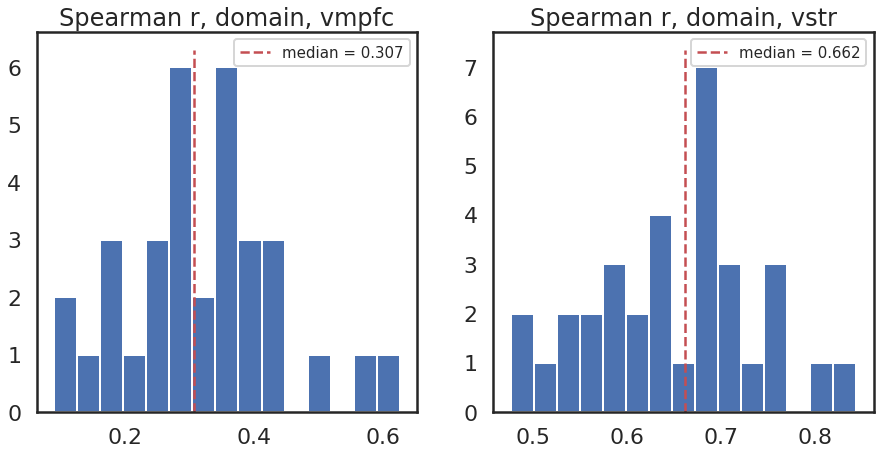

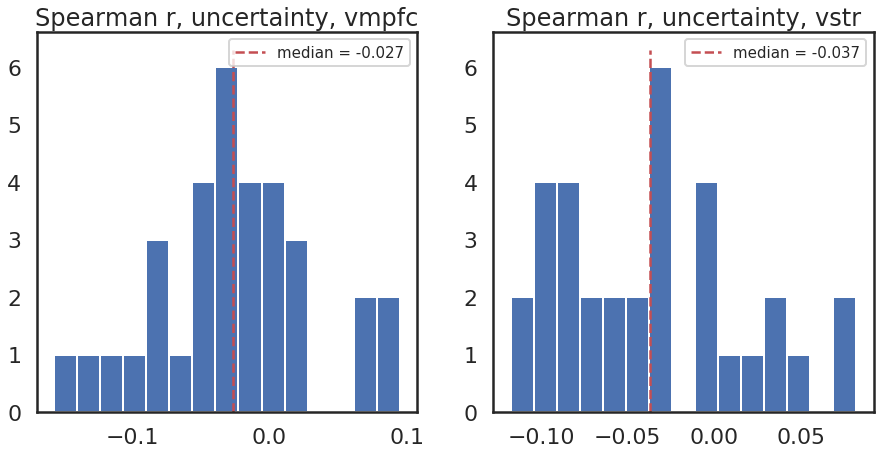

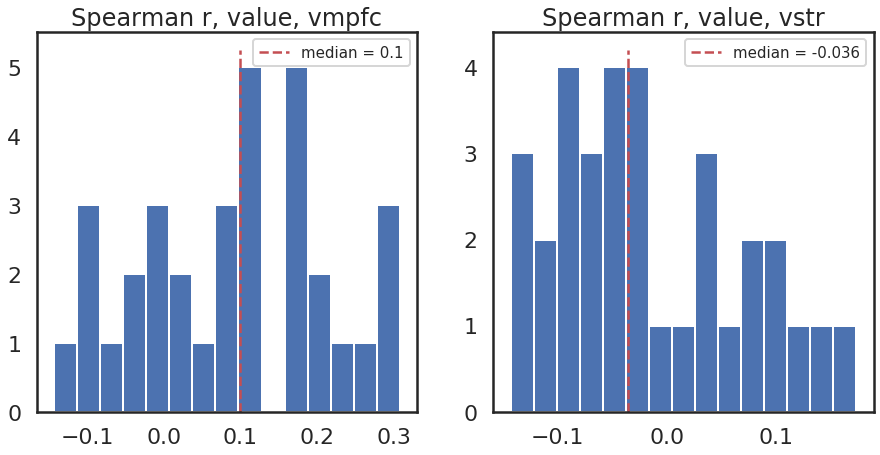

In [47]:
roi_names = ['vmpfc', 'vstr']

# plot correlation with model
spearman_r, spearman_p = compare_with_model(subjects, roi_names, mod_rdm_vector)

plot_r_hist(spearman_r)

In [ ]:
# plot null distribution from permutation 
spearman_r_perm = permutation_test(subjects, roi_names, mod_rdm_vector,
#                                   iter_num = 200, perm_num = 50 # default: 1000, 100
                                  )

# save permutation results into somewhere

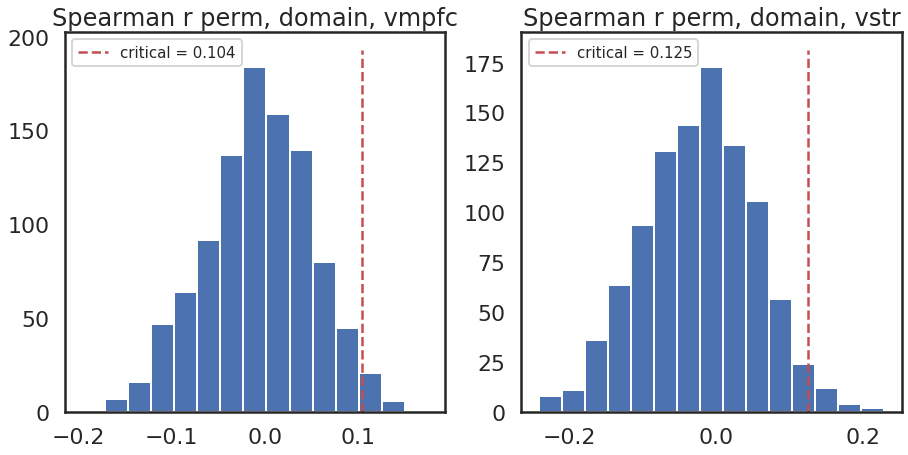

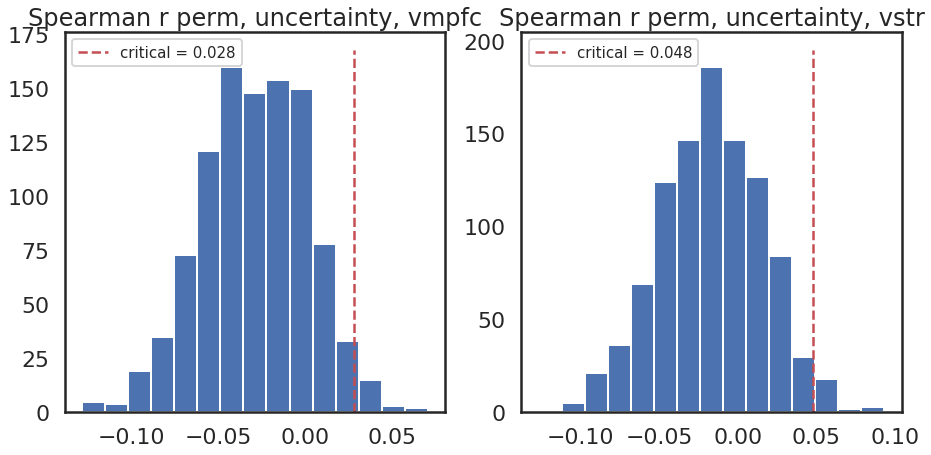

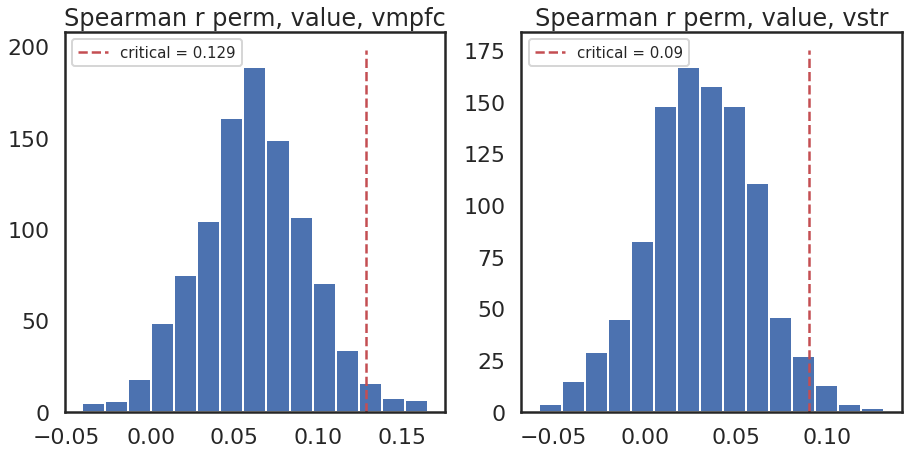

In [69]:
plot_permutation_null(spearman_r_perm)

### Parahippocampal areas <a class="anchor" id="hippo"></a>

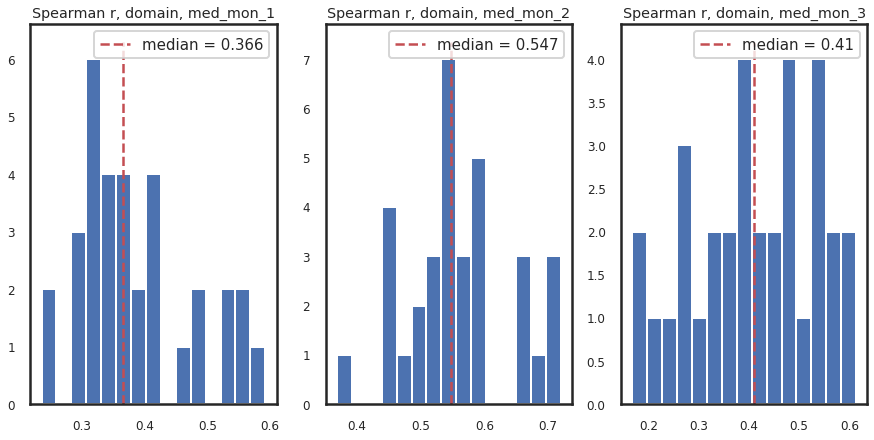

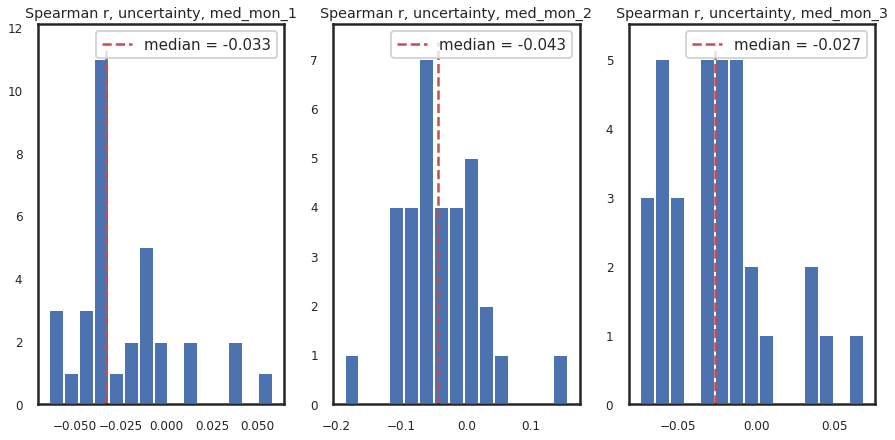

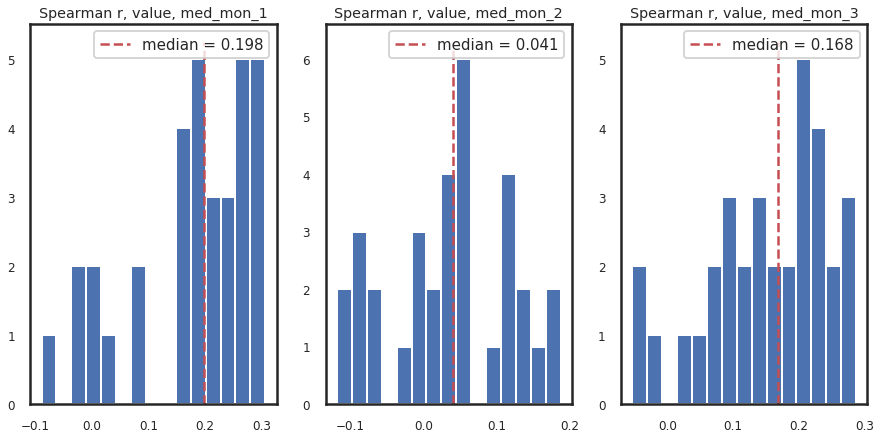

In [80]:
roi_names = ['med_mon_1', 'med_mon_2', 'med_mon_3']

# plot correlation with model
spearman_r, spearman_p = compare_with_model(subjects, roi_names, mod_rdm_vector)

plot_r_hist(spearman_r)

In [ ]:
# plot null distribution from permutation 
spearman_r_perm = permutation_test(subjects, roi_names, mod_rdm_vector,
#                                   iter_num = 200, perm_num = 50 # default: 1000, 100
                                  )


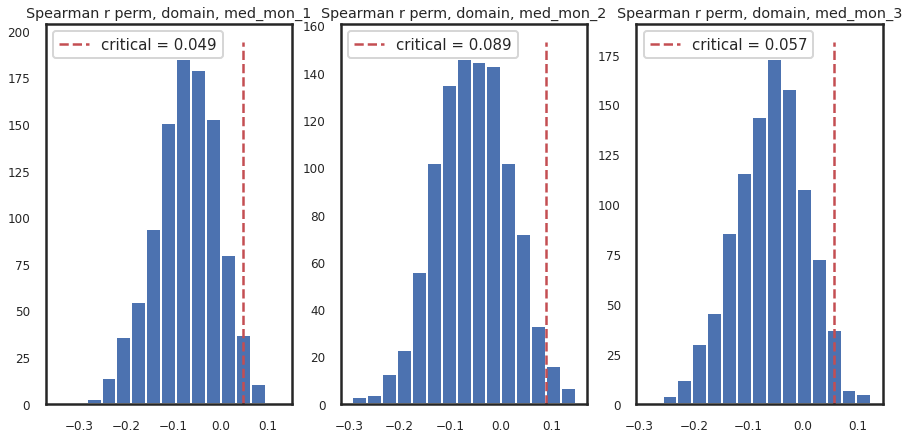

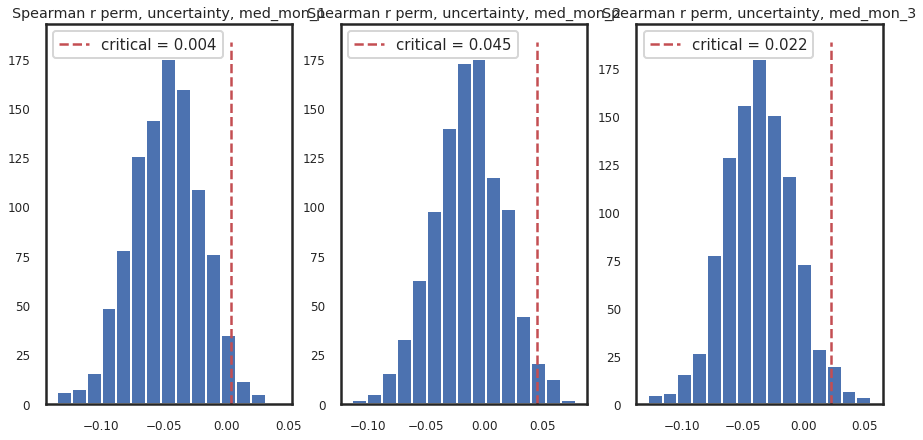

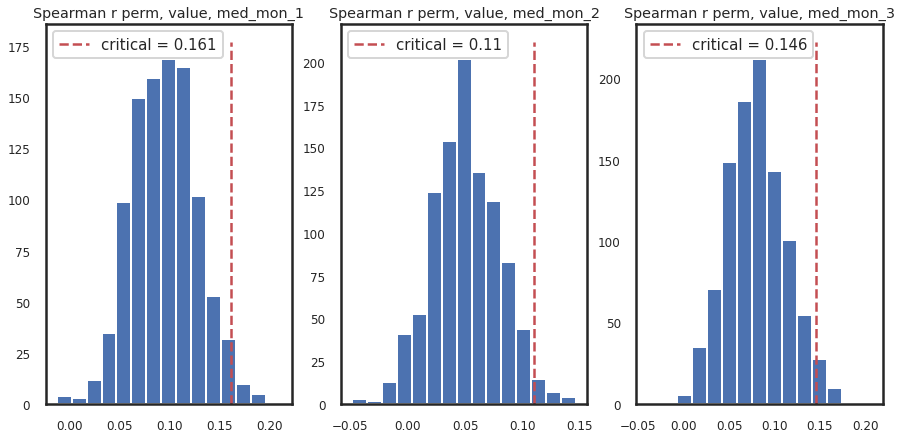

In [79]:
plot_permutation_null(spearman_r_perm)